# Retraining of the network

Use the already trained network as starting point and retrain it with new data to be more performant on this type of data

## Choose the retraining parameters

In [13]:
talkative = True  ## print info messages

from dextrusion.DialogParameters import DialogParameters
diag = DialogParameters()
diag.dialog_retrain()

nepochs = int(diag.epochs)
naug = float(diag.aug)
modeldir = diag.modelf
path = diag.path
validation_ratio = float(diag.ratio)

# The new model will be saved in the same directory as previous model with same name + "retrained"
newmodelpath = modeldir+'_retrained/'

: 

In [1]:
talkative = True
nepochs = 100
naug = 3.0
modeldir = "/Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notumAll1"
path = "/Users/yuyangsmacbook/Desktop/annotation_new"
validation_ratio = 0.2
batch_size_gui = 50
image_scaling_um = 0.275
newmodelpath = modeldir + "_retrained/"


## Load the previous network

In [2]:
from dextrusion.DeXtrusion import DeXtrusion
dexter = DeXtrusion(verbose=talkative)
dexter.load_model(modeldir)
dexter.retrain_parameters( model_path=newmodelpath, datapath=path, aug=naug, epoch=nepochs )

Tensorflow with Cuda: False
Tensorflow version: 2.15.0
Num GPUs Available:  0


## Load training and validation data

In [3]:
from dextrusion.MovieGeneratorFromROI import MovieGeneratorFromROI
train = MovieGeneratorFromROI(
                 data_path = path,
                 batch_size=dexter.batch_size,
                 frame_shape=dexter.nframes,
                 win_halfsize = dexter.half_size,
                 val_ratio=validation_ratio,
                 balance=True,
                 ncat=dexter.ncat,
                 cat_names = dexter.catnames,
                 naug=naug,
                 augment_withnoise=True,
                 add_nothing_windows=2,
                 verbose=talkative)

if talkative:
    print("Training size: "+str(train.__len__()*dexter.batch_size))
    print("Nb of batchs: "+str(train.__len__()))

valid = train.get_validation_generator()
if talkative:
    print("Validation size: "+str(valid.__len__()*dexter.batch_size))

Found files: 
/Users/yuyangsmacbook/Desktop/annotation_new/049_100.tif
Nrois 200.0
Training size: 2000
Nb of batchs: 40
Validation size: 500


### ReTrain the network, and save it

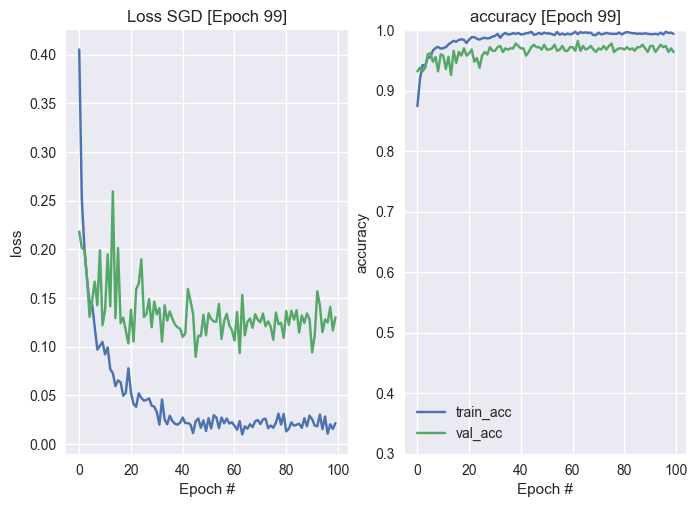

40/40 [==============================] - 11s 271ms/step - loss: 0.0213 - acc: 0.9940 - val_loss: 0.1300 - val_acc: 0.9640 - lr: 1.0000e-08
----- Training in 17.529866218566895 minutes ----
INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notumAll1_retrained/assets


INFO:tensorflow:Assets written to: /Users/yuyangsmacbook/project/dextrusion-main/DeXNets/notum_all/notumAll1_retrained/assets


In [4]:
dexter.train_model(train_generator=train, validation_generator=valid, epochs=nepochs)  ## launch the retraining and save the new network
train.clean_tempdir()  ## remove the created files used for the training and validation

In [7]:
print("len(train) =", len(train)) 
print("batch_size =", dexter.batch_size)
print("n_train_windows =", len(train.trainindex))
print("n_val_windows   =", len(train.valindex)) 
print("check:", len(train.trainindex) // dexter.batch_size)


len(train) = 40
batch_size = 50
n_train_windows = 2013
n_val_windows   = 503
check: 40
